<a href="https://colab.research.google.com/github/ghlai9665/transformer-implementation/blob/main/Transformer_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
# Helper functions for examining GPU memory
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
print(GPUs)
gpu = GPUs[0]
print(gpu)
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

import gc
def print_allocations(mode='get_number'):
  # if you want to print out the actual tensors
  if mode == 'get_tensors':
    for obj in gc.get_objects():
        try:
            
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
        except:
            pass
  else:
    count = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
              count += 1
        except:
            pass
    print(count)
print_allocations()
print_allocations('get_tensors')

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=0789b48e03d299b4a5fb1b65989b7955f4dd4adc96f981d946a2180ddff11fe8
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 112.2 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
0


In [ ]:
# install dependencies
!pip install torch numpy matplotlib spacy torchtext==0.4.0 seaborn

     |████████████████████████████████| 61kB 3.0MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
# import dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [ ]:
printm()
print_allocations()

Gen RAM Free: 12.7 GB  | Proc size: 273.8 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
0


/usr/local/lib/python3.6/dist-packages/pandas/util/__init__.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


# Model's Components

## Helper Components & Functions

### Sublayer Connection

In [ ]:
# helper function that produces a ModuleList of N identifical layers
# ModuleList is just like a regular Python list except the Module it holds are visible to all Module methods
# You can initialize a ModuleList with an iterable (a Python list)
def clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
# layer normalization is a variation of batch normalization as applied to RNN (to reduce training time)
class LayerNorm(nn.Module):
  # called in SublayerConnection like this:  self.norm = LayerNorm(size)
  # so features is size, which is d_model=512 in EncoderDecoder
  def __init__(self, features, eps=1e-6):
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps
  
  # perform layer normalization
  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
# residual connection
class SublayerConnection(nn.Module):
  def __init__(self, size, dropout):
    super().__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  # the sublayer function will be specified when you apply the res connection to it
  def forward(self, x, sublayer):
    # print("## forward in SublayerConnection")
    # sublayer is something like lambda x: self.self_attn(x,x,x,mask)
    # apply the res connection <-- I'm share comments' doubt whether it's actually equivalent to apply the norm first instead of last like in the paper
    return x + self.dropout(sublayer(self.norm(x)))

### Multi-head Attention

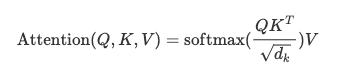

In [ ]:
# query -- Q, key -- K, value -- V. All are generated by multiplying the sentence input x_i with weight matrices W_Q, W_K, W_V
# input is Q, K, V, output is the weighted average of every word in the sentence
def attention(query, key, value, mask=None, dropout=None): 
  # torch.size is another name for torch.shape, d_k is set to be the last dimension of the query matrix
  d_k = query.size(-1) 

  scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
  # scores has shape (n, h, 1, 1) 
  # backslash just tells Python to extend the program over the next line
  # apply masking if necessary before softmax (optional, only for the decoder here)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9) # masked_fill is a pytorch method, setting the value to -1e9 where mask==0 is true
  # attn_weights is "p_attn" in the original annotated transformer, dim is the dimension along which the softmax will be applied
  attn_weights = F.softmax(scores, dim=-1)
  # apply dropout as necessary
  if dropout is not None:
    attn_weights = dropout(attn_weights)
  return torch.matmul(attn_weights, value), attn_weights



#### Dimensions when query, key, value pass through attention during its use in multi-head attention

(1) query, key, value are all of shape (n, h, 1, d_k)

(2) In step with scores, the batch multiplication (matmul) is on (n, h, 1, d_k) and (n, h, d_k, 1), resulting in (n, h, 1, 1) <-- for every token and every head, you multiplied the query and key to obtain a 1 * 1 score 

(3) You softmax and scale this score matrix (n, h, 1, 1) to get the attention weights (weights that each head assign to each of the n tokens in the sentence), which is of the same shape and the second return. 

You then multiply this attention weight matrix (n, h, 1, 1) with the value matrix (n, h, 1, dk) giving you the first return, a matrix of shape (n, h, 1, dk) <-- the value vector of each token is replaced by a weighted average of all tokens in the sentence. Note now we have for each of the n tokens, h versions of weighted average vector of size dk. We will use W_o to determine which head we should pay attention to.   



In [ ]:
'''
Multihead uses multiple attention functions (heads)
e.g. let n = 1, for each d_model * 1 input, instead of calculating a single attention, using Q K V of size d_model * 1  (maybe just doing Q=K=V=X),
we use 8 different attention (heads), using 8 different heads/set of Q K V of size (d_k = d_model/8) and then combine them using a final weight matrix W_O 
The computational cost is similar for the two but this multi-head approach allows us to focus on different parts of a sentence (front and back)
'''
class MultiHeadedAttention(nn.Module):
  # h is the number of heads, d_model is the dimension of the word embedding
  def __init__(self, h, d_model, dropout=0.1):
    super().__init__()
    
    assert d_model % h == 0 # ensure that d_model is a multiple of h

    self.h = h
    self.d_k = d_model // h

    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
    # print("### Multiheaded Attention initiated")
    # print("### h is: ", h)
    # print("### d_model is: ", d_model)
    # print("### d_k is: ", self.d_k)

    # we need 4 weight matrices: W_q, W_k, W_v, W_o, all of which have input size d_model and output size d_model
    self.linears = clones(nn.Linear(d_model, d_model), 4) # put these weight matrices in a ModuleList with the clones function

  def forward(self, query, key, value, mask=None):
    ''' in practice query, key, value will all just be x, the input vector of size d_model * 1
    Q = W_q @ query
    K = W_k @ key
    V = W_v @ value
    '''
    # global counter
    # if counter < 5:
      # print("### forward in MultiHeadedAttention")
      # print("### input query is shape: ", query.shape)
      # print("### input key is shape: ", key.shape)
      # print("### input value is shape: ", value.shape)
      # counter += 1

    if mask is not None:
      # apply the same mask to all h heads
      # we add a dimension at dimension 1 with unsqueeze, perhaps to allow broadcasting
      mask = mask.unsqueeze(1)

    # number of tokens (query is of size n * d_k where d_k = d_model is we pass x in as query)
    n = query.size(0)

      # get the Q, K, V for each of the 8 attention heads forward passing through l(x)
      # (1) l(x) returns the actual Q (W_q @ query), K (W_k @ key), V (W_v @ value)
      # zipped will return a list of tuples (linear function, input query/key/value)
      # (2) view reshape the output into the correct shape, which is h matrices of Q (W_q @ query), K (W_k @ key), or V (W_v @ value), of size n*d_k. 
      # If we set h to be higher, d_k will automatically to be lower
      # query Q, key K, value V will be stacked like the matrix in the bottom right corner in the picture
    query, key, value = \
        [l(x).view(n, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (query, key, value))] 
    # print("### reshaped query is shape: ", query.shape)
    # print("### reshaped key is shape: ", key.shape)
    # print("### reshaped value is shape: ", value.shape)
      # forward pass through each of the 8 attention heads
      # query, key, value all have shape (n, h, -1, d_k)
      # x -- weighted average for the input (n, h, -1, d_k), which is the result of the equation, self.attn -- the weights, second term in the equation (n, h, 1, 1)
    x, self.attn = attention(query, key, value, mask=mask, dropout = self.dropout)


      # concat attention vectors (LHS of the equation) from all heads
      # after transpose, x -- (n, -1, h, d_k)
      # transpose breaks contiguity, we need to call contiguous() to create a copy that has contiguity to be able to apply view
    x = x.transpose(1,2).contiguous() \
           .view(n, -1, self.h * self.d_k) # for each token n, instead of having h rows of d_k-sized attention vector, you now have one single long concated attention vector of size h * d_k

      # apply the final layer W_O to combine output from different heads
      # note now x has shape (n, 1, h*d_k) which is equivalent to (n, 1, d_model), an input shape accepted for the linears that we defined.
      # double checking that the shape fits: the input shape is (n, 1, d_model), weight is (1, d_model, d_model) for broadcast, output shape is (n, 1, d_model). Batch matrix multiplication is applied I think.
    return self.linears[-1](x)



#### l(x).view(n, -1, self.h, self.d_k).transpose(1,2) explained



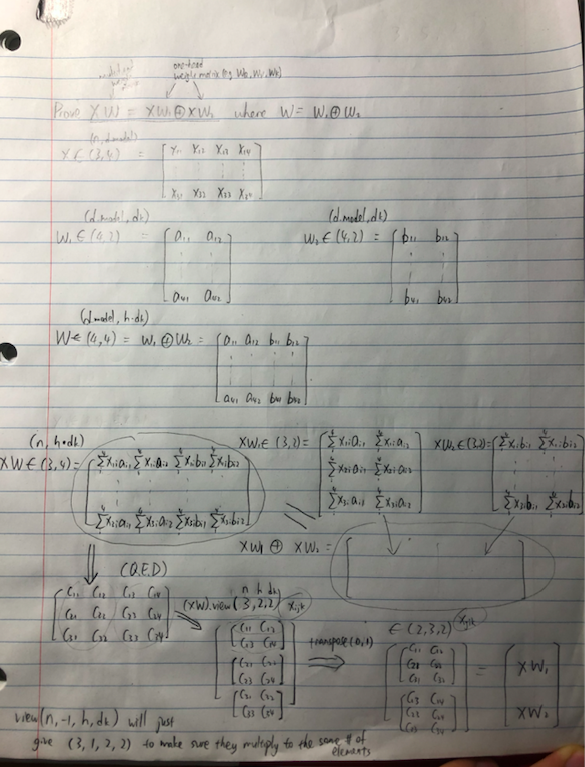








#### Shape of input & output of nn.Linear

x is the input of the linear function l(x). It has shape n * d_model. The matrix under Q.E.D is the output of l(x), which projects each d_model-sized vector to h d_k-sized vectors (h * dk columns), and it does this for each of the n tokens (n rows). So the output has shape n * d_model; more precisely, it has shape n * (h * d_k). Then, the view + transpose function will reshape the output to h matrices of shape (n * d_k) <-- this is essentially h heads of n d_k-sized query/key/value vectors (1 for each token)

#### Revision

Note that different from my notes above, in the actual code, the transpose (1,2) is performed on the shape (n, -1, h, d_k), resulting in the final output shape (n, h, -1, d_k). This just means that there will be n rows (each corresponding to one token) of h * d_k matrices (where each of the h rows correspond to a d_k-sized query/key/value vector) <-- this is all assuming that -1 will be converted to 1 in practice

#### Revision 2

Idk why he used (n, -1, h, d_k).tranpose(1,2) instead of (n, h, -1, d_k). Seems very unnecessary.


### Position-wise Feedforward

After the multi-head attention sub-layer, each token goes through a feedforward network, consisted of 1 linear transformation, 1 ReLu activation, 1 linear transformation.

It's kind of like z1 = w1 * x, then a = g(z1), then z2 = w2 * a

In [ ]:
class PositionwiseFeedForward(nn.Module):
  # input x is the output of the multi-head, which has shape (n, 1, d_model)
  # z1 and a will be (n, 1, d_ff), so w1 will be (n, d_model, d_ff)
  # z2 will be (n, 1, d_model), so w2 will be (n, d_ff, d_model)
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.w_1 = nn.Linear(d_model, d_ff) 
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super().__init__()
    self.d_model = d_model
    # initialize a embedding function that takes an input of size vocab 
    # and output an embedding of size d_mdel
    self.embed = nn.Embedding(vocab, d_model)
  
  def forward(self, x):
    # return the scaled embedding
    return self.embed(x) * math.sqrt(self.d_model)

In [ ]:
?nn.Embedding

### Positional Encoding

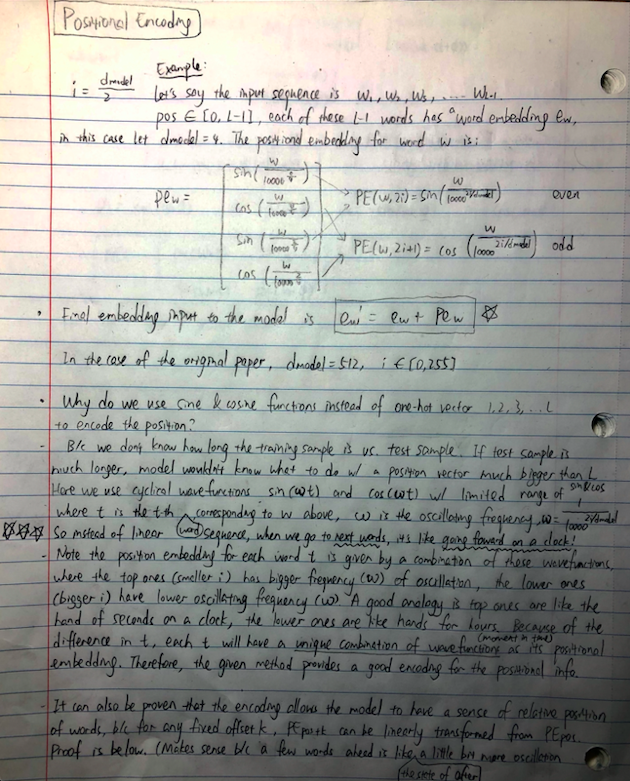

In [ ]:
# Imagine a clock. i corresponds to different freqs of hands -- there are d_model/2 different frequencies. So frequencies depend solely on the variable i. 
# Visualize the positional embedding for each word/timestep(pos), we have pairs of sine and cosine of the same frequencies (i), moving down, the deeper, the slower the frequency
# When we go to the next word, all of the hands of the clock move forward a bit. 
# pos * freq correspond to how much distance each hand has moved for each word, we forward them through sine and cosine to get the actual positions of each hand on the clock

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout, max_len=5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    # initialize position embedding matrix
    pe = torch.zeros(max_len, d_model)
    pos = torch.arange(0, max_len).unsqueeze(1)
    freq = torch.exp(torch.arange(0., d_model, 2) * # 2i, where i ranges from 0 to d_model/2 
        -(math.log(10000.0)/d_model)) 
     # we store freq in log space (log reduction) to save memory; simplifying will get us the equivalent omega

    pe[:, 0::2] = torch.sin(pos * freq) # pos is shape(max_len, 1), freq is (1, d_model/2), resulting in shape (max_len, d_model/2)
    pe[:, 1::2] = torch.cos(pos * freq) 
    # pos * freq is essentially multiplying each time step (word) with its frequency vector (different freqs for different depth of word embedding),
    # resulting in a matrix where each row is a d_model-sized/2 vector storing w*t (analogous to how much distance the hand has moved on the clock) for each of the words
    # To get the actual position on the clock from the distance the hands have moved, we need the sine and cosine
    # for the odd depths in the embedding, we forward the distances through the sine function, for the even depths in the embedding, we forward the distances through the cosine function
    pe = pe.unsqueeze(0) # now pe is (1, max_len, d_model/2) <-- need to double check this
    self.register_buffer('pe', pe) # buffer is like a parameter, but not updated during gradient descent

  def forward(self, x):
    # x += Variable(self.pe[:, :x.size(1)], requires_grad=False) # Variable is the same Tensors now -- but in the old days you need Variable to set requires_grad=False
    x += self.pe[:, :x.size(1)]
    return self.dropout(x)

### Mask

In [ ]:
# must specify the tensor's device because it's not determined by src or trg tensor
def subsequent_mask(size, device=torch.device('cpu')):
  # mask subsequent tokens (in decoder)
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') 
  # create an attn_shape matrix filled with 1's, where everything below the 1st diagonal above the main diagnol are zeroed out. In other words, the upper triangle include elements from 1st diagonal and up
  # note that each row represents a token, each true columns for that row represents the tokens that the token can attend to. Notice each token can only attend to the tokens before itself (including).
  return (torch.from_numpy(subsequent_mask) == 0)

## Encoder

### Encoder Layer



In [ ]:
# This is the fundamental component of encoder.
# Each layer has 2 sublayers: (1) a multi-head self-attention mechanism (2) position-wise fully connected feedforward network
class EncoderLayer(nn.Module):
  # instantiation requires 4 args. In our case, self_attn  is the multi-head attention, feed_forward is PositionwiseFeedForward.
  def __init__(self, size, self_attn, feed_forward, dropout):
    super().__init__()
    self.self_attn = self_attn # multi-head
    self.feed_forward = feed_forward # position-wise feedforward
    self.sublayer = clones(SublayerConnection(size, dropout), 2) # instantiate the 2 SublayerConnection objects, store in a ModuleList
    # sublayer is a list of two res connections, self_attn will use sublayer[0] as its res connection, feed_forward will use sublayer[1]
    self.size = size
  
  def forward(self, x, mask):
    # Call the forward function on the SubConnection objects (they have already been instantiated above)
    # recall SubConnection's forward takes 2 args: (1) x (2) a sublayer function, which we specify here as a lambda function It'll take self.norm(x) as its input and output self.self_attn(self.norm(x),self.norm(x),self.norm(x),mask).
    # print("## forward in EncoderLayer")
    x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,mask)) # forward through self_attn with res connection, store result in x
    return self.sublayer[1](x, self.feed_forward) # forward through feed_forward with res connection

### Encoder Core


In [ ]:
# Encoder depends on 3 methods: clone(), LayerNorm(), EncoderLayer()
class Encoder(nn.Module):
  # instantiated with 2 args: type of encoder layer & how many layers
  def __init__(self, layer, N):
    super().__init__()
    # define the layers (the essence of the Encoder)
    self.layers = clones(layer, N)
    # every res connection is followed by a layer normalization
    self.normalize = LayerNorm(layer.size)
  
  def forward(self, x, mask):
    # print("## forward in Encoder")
    for layer in self.layers:
      x = layer(x, mask) # this is defined as EncoderLayer in our code
    return self.normalize(x) # follow the forward pass (with res connection) by a layer normalization

## Decoder

### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super().__init__()
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)
    self.size = size
  
  def forward(self, x, memory, src_mask, tgt_mask):
    # print("#### x is shape: ", x.shape)
    # print("#### memory is shape ", memory.shape)
    # self_attn is identical to encoder's self_attn
    x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
    # src_attn's query vector is the shape of x (first part of the decoder), whereas m is the shape of the output of encoder
    x = self.sublayer[1](x, lambda x: self.src_attn(x,memory,memory,src_mask))
    return self.sublayer[2](x, self.feed_forward)


### Decoder Core



In [ ]:
class Decoder(nn.Module):
  def __init__(self, layer, N):
    super().__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size) # instantiate the LayerNorm object
  
  def forward(self, x, memory, src_mask, tgt_mask):
    # forward through every layer
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

## Generator

Generator is just the final layer (linear + softmax) after the decode

In [ ]:
class Generator(nn.Module):
  def __init__(self, d_model, vocab):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab) # define the linear projection, which takes d_model sized activation and output linear mapping to assign probability to each of the vocab
  
  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## EncoderDecoder

In [ ]:
# The fundamental base for the entire model
# has three methods, forward function (makes prediction) which utilizes the encode function to encode src sentence then decode function to output. 
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    # super().__init__() allows you to find the correct base class to inherit the __init__ function from
    super().__init__()
    # define all the params as specified by the user in the instantiation
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed # a embedding function
    self.tgt_embed = tgt_embed # a embedding function
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    # print("## forward in EncoderDecoder")
                        # memory                    #src_mask #tgt #tgt_mask
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
  
  # takes 4 args
  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
  
  # takes 2 args
  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)


# Full Model

In [ ]:
# note only 2 args are required to initialize a model. d_model is model dimension, d_ff is feedforward dimension, N is # of times layers are repeated
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
  # define deepcopy as c
  c = copy.deepcopy
  # define the multi-head attention
  attn = MultiHeadedAttention(h, d_model)
  # define the feedforward network
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout) # idk why max_len is not given
  # define the overall model with the three components above
  model = EncoderDecoder(
    Encoder( EncoderLayer(d_model, c(attn), c(ff), dropout), N ), # Encoder takes two args
    Decoder( DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N ), # Decoder takes two args
    nn.Sequential( Embeddings(d_model, src_vocab), c(position) ), # Sequential (takes two args) that gives source embedding
    nn.Sequential( Embeddings(d_model, tgt_vocab), c(position) ), # Sequential (takes two args) that gives target embedding
    Generator(d_model, tgt_vocab) # Generator takes two args
    )

  # parameters initalization (important details in the original authors' code) with Glorot / fan_avg
  for p in model.parameters(): # parameters() is a method in nn, which EncoderDecoder inherits
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  
  return model

#### Additional Notes (Might Not Be Useful)

# Training Tools


In [ ]:
# test_model = make_model(10, 10, 2)

## Optimizer


In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Batch Object

In [ ]:
# This is how we pass input sentence pairs <English sentence, German sentence> into the initialized model that we want to train
# Note the model's forward takes 4 parameters: src, tgt, src_mask, tgt_mask 
''' In run_epoch, batch objects are used like this
out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
loss = loss_compute(out, batch.trg_y, batch.ntokens)
'''
class Batch: 
  # The object is created by taking input sentence pairs <English sentence, German sentence>
  def __init__(self, src, trg=None, pad=0):
    # src is English sentences, of shape batch_size * sentence_len
    # trg is German sentences, of shape batch_size * sentence_len
    self.src = src 
    self.src_mask = (src != pad).unsqueeze(-2) 
    
  # src = (batch.size, seq.len) -> != pad -> 
        # (batch.size, seq.len) -> usnqueeze ->
        # (batch.size, 1, seq.len) adds a dimension at -2
        # e.g., src=[ [2,1,3,4], [2,3,1,4] ] correspond to
        # src_mask=[ [[1,1,1,1], [1,1,1,1]] ]
        # mask will be 1 at where there should be values, 0 at where should be masked

    if trg != None:
      self.trg = trg[:, :-1] # src is the condition in the probability, trg + src is used to predict trg_y in the decoder
      self.trg_y = trg[:, 1:] # trg_y is the "answer" you're training the model (minimize the loss) for, shifted 1 to the right compared to self.trg
      self.trg_mask = self.make_std_mask(self.trg, pad)
      self.ntokens = (self.trg_y != pad).sum() # count how many non-blank tokens there are

  @staticmethod
  def make_std_mask(tgt, pad):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # the method is made static because it could be used independent of object Batch
    # hide padding (give 0 where is equal to padding)
    tgt_mask = (tgt != pad).unsqueeze(-2)    
    
    # mask out previous words & combine the masks
    tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1), device).to(device=device)
    return tgt_mask

## Label Smoothing (Regularization)


In [ ]:
# we want to replace 0s with smoothing/(k-1) and 1s with 1-smoothing
class LabelSmoothingLoss(nn.Module):
  def __init__(self, vocab_size, padding_idx, smoothing=0.0):
    super().__init__()
    self.compute_loss = nn.KLDivLoss(size_average=False) # forward of nn.KLDivLoss takes (prediction, target) and return the loss
    self.padding_idx = padding_idx
    self.smoothing = smoothing
    self.confidence = 1.0 - smoothing
    self.vocab_size = vocab_size
    self.target_smoothed = None

  def forward(self, pred, target):
    # pred should be shape (batch.size * sentence.len, vocab_size)
    # example of batch size 1:
    # pred = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233], word1
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233], word2
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]]) word3
    # target should be shape (batch.size * sentence.len, ) 
    # example target = tensor([2, 1, 0]) 
    assert pred.size(1) == self.vocab_size
    # create the label-smoothed target
    target_smoothed = pred.clone() # copy the shape of pred
    
    target_smoothed.fill_(self.smoothing / (self.vocab_size-2)) # minus 2 bc first col'n <blank> is always 0
    target_smoothed.scatter_(1, target.unsqueeze(1), self.confidence) # write smoothed targets into target_smoothed 
    # find the <blank> words and zero them out
    target_smoothed[:, self.padding_idx] = 0 # padding_index marks the col'n for <blank>
    blanks = torch.nonzero(target == self.padding_idx) # select the indices of <blank> tokens in target (which returns 1 for the truth statement)
    if blanks.dim() > 0: # if <blank> tokens exist
      # zero out those rows
      target_smoothed.index_fill_(0, blanks.squeeze(), 0.0)
    # store the label-smoothed target we just created
    # self.target_smoothed = target_smoothed
    # return the loss
    return self.compute_loss(pred, target_smoothed)

In [ ]:
printm()

Gen RAM Free: 12.7 GB  | Proc size: 287.3 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
# Example 1
crit = LabelSmoothingLoss(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
predict = predict.masked_fill(predict == 0, 1e-9) 
print(predict)
loss = crit(predict.log(),
            torch.LongTensor([2,1,0]))
print(loss)

# Example 2
crit = LabelSmoothingLoss(5, 0, 0.4)
predict = torch.FloatTensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
loss = crit(predict.log(),
            torch.LongTensor([2,1,0]))
del loss
del crit
del predict

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([[1.0000e-09, 2.0000e-01, 7.0000e-01, 1.0000e-01, 1.0000e-09],
        [1.0000e-09, 2.0000e-01, 7.0000e-01, 1.0000e-01, 1.0000e-09],
        [1.0000e-09, 2.0000e-01, 7.0000e-01, 1.0000e-01, 1.0000e-09]])
tensor(5.3571)


In [ ]:
printm()

Gen RAM Free: 12.7 GB  | Proc size: 295.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


Gen RAM Free: 12.7 GB  | Proc size: 295.8 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


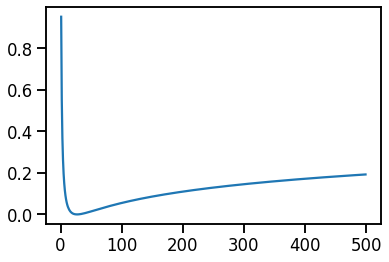

In [ ]:
# Example 3 showing how Label Smoothing adjusts/smoothes the hard target.
# Optimizing for the hard target now no longer generates the minimum loss - this is what we want because sometimes the label/hard target could be wrong
crit = LabelSmoothingLoss(5, 0, 0.1)
def loss(x):
  d = x + 3
  pred = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]]) # 1 word sentence
  return crit(pred.log(), torch.LongTensor([1]))
  # Note we're computing the loss between [0, x / d, 1 / d, 1 / d, 1 / d] and [0, 1, 0, 0, 0]
  # As x approach inf, the more confident/hard the prediction is
x = np.arange(1,500)
y = [loss(x) for x in range(1,500)]
plt.plot(x, y)
del crit
del x
del y
printm()

## Training Function

In [ ]:
# The object performs forward prop, computes loss using criterion and performs backprop
class TrainingFunction:
  def __init__(self, generator, criterion, opt=None, device=torch.device('cpu')): # criterion is a loss function such as LabelSmoothingLoss
    self.generator = generator
    self.criterion = criterion
    self.opt = opt 

  def __call__(self, x, y, norm):
    # forward pass inputs x (the output after the decoder) into the generator (linear + softmax)
    x = self.generator(x) 
    # y = y.to(device=device)
    # calculate the loss and perform backward propagation. We can normalize the loss by dividing by the number of tokens (which is a constant in a sample)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1)) / int(norm)
    # update the gradient 
    if self.opt is not None:
      loss.backward() # computes the gradient 
      self.opt.step()
      self.opt.optimizer.zero_grad() # clears the gradient (otherwise gradient will accumulate from previous steps)
    return float(loss)

# Trivial Example

## Synthetic Data

In [ ]:
# This function below generates batches of source + target sentences
# data_gen is a generator (memory-less iterator) function. You need to keep looping to get Batch objects (nbatches in total)  
# V is the upper bound value for the synthetic data
# each batch is made of `batch` number of sentences of len 10, and there're nbatches
def data_gen(V, batch, nbatches):
  for i in range(nbatches):
    # np.random.randint will generate a array of shape size, filled with random int between [1,V)
    d = np.random.randint(1, V, size=(batch,10))

    # set the first element of all rows (batches) to be 1 
    d[:, 0] = 1
    # src will be a torch tensor of size batch * 10
    src = torch.tensor(d, requires_grad=False) # input sentence
    tgt = torch.tensor(d, requires_grad=False) # output sentence
    yield Batch(src, tgt, 0)

## Training Loop

In [ ]:
# run one epoch. Every epoch is an iteration over the entire training set (how many steps are in one epoch depends on the batch_size)
def run_epoch(data, model, loss_compute, epoch_idx):
  # data is an iterable that holds the training data 
  # model is EncoderDecoder object e.g. make_model(V, V, N=2)
  # loss_compute e.g. TrainingFunction(model.generator, criterion, model_opt)
  print("## training epoch: ", epoch_idx)
  # varialbes for logging
  start = time.time()
  total_loss = 0
  total_tokens = 0
  cur_tokens = 0 # cleared every 50 steps

  # train the model batch-by-batch 
  for i, batch in enumerate(data):
    batch.src = batch.src.to(device=device)
    batch.trg = batch.trg.to(device=device)
    out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask) # passes input through encoder then decoder
    loss = float(loss_compute(out, batch.trg_y, batch.ntokens)) # e.g. TrainingFunction(x, y, norm), which passes input through generator, performs backprop and returns loss
    total_loss += loss
    # if i < 5:
    #   print("total_loss: ", total_loss)
    #   print("batch.ntokens int: ", int(batch.ntokens))
    total_tokens += int(batch.ntokens)
    cur_tokens += int(batch.ntokens)

    # log for every 50 batches(steps)
    if i % 50 == 1:
      elapsed = time.time() - start
      print("-----")
      print("Epoch step: %d  Average Loss Per Token in the Last Step: %f  Processed Tokens per Sec in the Last 50 Steps %f" % (i, loss / int(batch.ntokens), cur_tokens / elapsed))
      printm()
      print_allocations()
      start = time.time()
      cur_tokens = 0
  return total_loss / total_tokens # average loss

## Start Training

In [ ]:
# V = 11
# criterion = LabelSmoothingLoss(vocab_size=V, padding_idx=0, smoothing=0.0)
# # def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1)
# model = make_model(V, V, N=2)
# model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
#         torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# print(model)

# # train for 10 epochs
# for epoch in range(13):
#   # set to train mode so things like dropout work (note this function doesn't train the model itself per se)
#   model.train() 
#   # actually train the model by generating random data using data_gen on the fly which has the identical source & target sentence pairs
#   run_epoch(data_gen(V, 30, 20), model, TrainingFunction(model.generator, criterion, model_opt))
#   # set to eval model to check how good the model is after each loop
#   model.eval()
#   # generate test data on the fly to evaluate
#   print(run_epoch(data_gen(V, 30, 5), model, TrainingFunction(model.generator, criterion)))

In [ ]:
def accuracy(tensor1, tensor2):
  length = tensor1.shape[1]
  count = 0
  for i in range(length):
    if (tensor1[0][i] == tensor2[0][i]):
      count += 1
  return count / length

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [ ]:
# model.eval()
# src_mask = torch.ones(1, 1, 10) 
# src = torch.tensor([[1,2,3,4,5,6,7,8,9,10]])

# # src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
# # src_mask = Variable(torch.ones(1, 1, 10) )
# fin = greedy_decode(model, src, src_mask, max_len=10, start_symbol=1)
# print(fin)
# print(accuracy(src, fin))
# #print("### src shape ", src.shape)
# n = 30
# accuracy_total = 0
# for _ in range(n):
#   src = torch.randint(1,9, size=(1,10))
#   src_mask = torch.ones(1, 1, 10) 
#   fin = greedy_decode(model, src, src_mask, max_len=10, start_symbol=1)
#   print("**** src is: ", src)
#   print("**** fin is: ", fin)
#   accuracy_cur = accuracy(src, fin)
#   print("**** accuracy_cur is: ", accuracy_cur)
#   accuracy_total += accuracy_cur
# print(accuracy_total / n)

# Real Example

## Load Data

In [ ]:
!pip install spacy
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 537kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=c1cef922faeafee5ce3eb6fa64a955891aa234ab9b108dfb458dd4f75fe43a18
  Stored in directory: /tmp/pip-ephem-wheel-cache-p797e_pd/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
from torchtext.datasets import IWSLT
from torchtext.data import Field, BucketIterator

# define the tokenizers and params for the data (i don't think Spacy does subword tokenization)
SRC = Field(tokenize = "spacy",
            tokenizer_language = "de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)
TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

# split data into train, validate, and test group
train_data, valid_data, test_data = IWSLT.splits(exts = ('.de', '.en'),
                                                 fields = (SRC, TRG))


downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:07<00:00, 3.36MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/train.tags.de-en.de
.data/iwslt/de-en/train.tags.de-en.en


In [ ]:
# build a vocabulary to index words with numbers; you can go from word to number via SRC.vocab.stoi
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
# We arranges the batches by using BucketIterator
from torchtext.data import BucketIterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is: ", device)

BATCH_SIZE = 16
# BucketIterator batches sentences of similar lengths together to minimize padding
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE)
    #device = device)

device is:  cuda


In [ ]:
def batchify(batch, pad_idx, device):
  src, trg = batch.src.transpose(0,1).to(device=device), batch.trg.transpose(0,1).to(device=device)
  return Batch(src, trg, pad_idx)


## Start Training

In [ ]:
# To be modified to train this real example
# size of the source vocab
src_vocab_size = len(SRC.vocab.itos)
tgt_vocab_size = len(TRG.vocab.itos)

pad_idx = TRG.vocab.stoi['<pad>']
print("pad_index: ", pad_idx)

criterion = LabelSmoothingLoss(vocab_size=tgt_vocab_size, padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()

model = make_model(src_vocab_size, tgt_vocab_size, N=1, d_model=128, d_ff=128, h=8)
model.cuda()
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

pad_index:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   67735 KB |   67735 KB |   67735 KB |       0 B  |\n|       from large pool |   66568 KB |   66568 KB |   66568 KB |       0 B  |\n|       from small pool |    1167 KB |    1167 KB |    1167 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |   67735 KB |   67735 KB |   67735 KB |       0 B  |\n|       from large pool |   66568 KB |   66568 KB |

In [ ]:
printm()

Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
print_allocations()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


52


In [ ]:
# train for 10 epochs
for epoch in range(5):
  # set to train mode so things like dropout work (note this function doesn't train the model itself per se)
  model.train() 
  # actually train the model by generating random data using data_gen on the fly which has the identical source & target sentence pairs
  printm()
  print_allocations()
  run_epoch((batchify(b, pad_idx, device) for b in train_iterator), model, TrainingFunction(model.generator, criterion, model_opt, device=device), epoch)
  # # set to eval model to check how good the model is after each loop
  model.eval()
  
  print(run_epoch((batchify(b, pad_idx, device) for b in valid_iterator), model, TrainingFunction(model.generator, criterion, device=device, opt=None), epoch))

Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Streaming output truncated to the last 5000 lines.
Epoch step: 1  Average Loss Per Token in the Last Step: 0.008558  Processed Tokens per Sec in the Last 50 Steps 1860.446791
Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
164
-----
Epoch step: 51  Average Loss Per Token in the Last Step: 0.011219  Processed Tokens per Sec in the Last 50 Steps 6739.614807
Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
164
-----
Epoch step: 101  Average Loss Per Token in the Last Step: 0.008889  Processed Tokens per Sec in the Last 50 Steps 7341.697529
Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
164
-----
Epoch step: 151  Average Loss Per Token in the Last Step: 0.007133  Processed Tokens per Sec in the Last 50 Steps 6980.069379
Gen RAM Free: 9.3 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
16

In [ ]:
from google.colab import files, drive
drive.mount('/content/gdrive')
model_name = 'checkpoint.pth'
path = F"/content/gdrive/My Drive/transformer/{model_name}" 
torch.save(model.state_dict(), path)

In [ ]:
model_name = 'checkpoint.pth'
path = F"/content/gdrive/My Drive/transformer/{model_name}" 

In [ ]:
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
state_dict = torch.load(path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
print(run_epoch((batchify(b, pad_idx, device) for b in test_iterator), model, TrainingFunction(model.generator, criterion, device=device, opt=None), 0))

## training epoch:  0
-----
Epoch step: 1  Average Loss Per Token in the Last Step: 0.014632  Processed Tokens per Sec in the Last 50 Steps 762.492230
Gen RAM Free: 9.2 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


116
-----
Epoch step: 51  Average Loss Per Token in the Last Step: 0.007563  Processed Tokens per Sec in the Last 50 Steps 21912.943787
Gen RAM Free: 9.2 GB  | Proc size: 5.0 GB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
116
0.008362555847731287


In [ ]:
for i, batch in enumerate(valid_iterator):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

RuntimeError: ignored